In [21]:
import os
import logging
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from sklearn import svm
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate, cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, roc_auc_score, make_scorer, SCORERS, confusion_matrix, roc_curve

In [22]:
path = "C:/Users/s1027177/OneDrive - Syngenta/Documents/BigData/Class8"
os.chdir(path)

In [23]:
seed = 2021

**0. Read the file**

In [4]:
#cll dataset
datafile = "cll_dataset.csv"
cll = pd.read_csv(datafile, sep=",")
cll.head()
# a row is a sample = a patient
# column 'Treat6m' recurrence of the disease, 1 if true, 0 if false
# other columns are features = rate of several types of cells and molecules in the patient

,Treat6m,Naive,EMRA,CM,EM,CD11a,CXCR3,CCR5,CXCR4,CXCR5,...,GzB,GzA,CD127,CD58,GAL-3,CD5,ICAM-1,CD38,CCR4,CTLA-4
0,1,0.0304,0.260,0.0150,0.2580,0.9346,0.775552,0.070052,0.339160,0.546893,...,0.781068,0.901904,0.200926,0.476314,0.818068,0.946954,0.990000,0.262730,0.270001,0.163433
1,0,0.1560,0.269,0.0387,0.0832,0.7110,0.812970,0.273710,0.375861,0.361873,...,0.425790,0.544353,0.053836,0.580217,0.469866,0.998994,0.997190,0.145660,0.321924,0.041356
2,1,0.0646,0.211,0.0363,0.2940,0.8970,0.539334,0.070597,0.162852,0.195341,...,0.780501,0.932139,0.321604,0.484588,0.762041,0.993183,0.997586,0.385564,0.249591,0.062653
3,0,0.0283,0.240,0.1180,0.1300,0.9861,0.857143,0.169069,0.199353,0.307644,...,0.864433,0.987819,0.382722,0.602925,0.645262,0.988252,0.999200,0.170346,0.400480,0.067871
4,0,0.0653,0.216,0.0949,0.2040,0.9209,0.847934,0.245060,0.182395,0.174046,...,0.609748,0.932809,0.373745,0.340299,0.102806,0.980924,0.996289,0.148594,0.156187,0.000000


In [5]:
pd.value_counts(cll["Treat6m"])

0    24
1     7
Name: Treat6m, dtype: int64

**1. Create X the features, Y the predictions**

In [6]:
Y = cll["Treat6m"]
X = cll.iloc[:,1:]

**2.**
* Create a function 'fit_rf' that fit random forests on xtrain, ytrain
* It should return the random forest score on the xtest, ytest set.
* Use sklearn implementation

In [7]:
def fit_rf(X, Y, seed, test_size):
    
    '''
      Split the dataset into test and train set. Fit a Random Forest and compute the score.

      Parameters 
      ----------
      X: array 
        Values of all the features/predictors
      Y: array 
        Values of the target variable
      test_size: float 
        Proportion of the dataset to include in the test split
      seed: int
        Controls the random_state parameter in sklearn RandomForestClassifier 

      Returns
      -------
      Accuracy of the prediction
      
    '''
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y)
    
    rf = RandomForestClassifier(random_state=seed)
    rf.fit(x_train, y_train)
    score = rf.score(x_test,y_test)
    
    return score

**3.**
* Create a function 'repeat_experiment' that will re-shuffle the dataset and fit a classifier a hundred times
* Store the score at each iteration
* Return the average score on the hundred iterations

In [8]:
def repeat_experiment(X, Y, seed, test_size=0.2, B=100):
    
    '''
    Re-shuffle the dataset and fit a classifier B times. Get the average score on the B iterations.

        Parameters 
        ----------
        X: array 
            Values of all the features/predictors
        Y: array 
            Values of the target variable
        test_size: float 
            Proportion of the dataset to include in the test split
        seed: int
            Controls the random_state parameter in sklearn RandomForestClassifier 
        B: int
            Number of iterations

        Returns
        -------
        Average accuracy on the B predictions

    '''
    scores = []
    
    while len(scores) < B:
        scores.append(fit_rf(X, Y, seed, test_size))
        
    return sum(scores)/len(scores)

**4. Is it good (check score averaged over a hundred experiments)**

In [9]:
print("The average score over a hundred experiments is: %.2f" %  repeat_experiment(X, Y, seed=seed))

The average score over a hundred experiments is: 0.70


The accuracy is high. It seems quite good at first sight.

**5. Is it actually good ? Try to predict only vectors with 'Treat6m' = 1. You can compute per-class precision, recall, f-scores...**

In [10]:
def one_class_fit(X, Y, seed, target_class=1, test_size=0.2, B=100):
    
    '''
    Re-shuffle the dataset and fit a classifier B times. Get the average score on the B iterations for only one class.

        Parameters 
        ----------
        X: array 
            Values of all the features/predictors
        Y: array 
            Values of the target variable
        target_class: int
            Category of the binary variable for which to predict
        test_size: float 
            Proportion of the dataset to include in the test split
        seed: int
            Controls the random_state parameter in sklearn RandomForestClassifier 
        B: int
            Number of iterations

        Returns
        -------
        Average accuracy on the B predictions for the class specified.

    '''  
    scores = []
    
    while len(scores) < B:
        
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y)
    
        rf = RandomForestClassifier(random_state=seed)
        rf.fit(x_train, y_train)
        
        x_test_ = x_test[y_test==target_class]
        y_test_ = y_test[y_test==target_class]
        
        if len(x_test_) > 0 :
            score = rf.score(x_test_, y_test_) 
            scores.append(score)

    return sum(scores)/len(scores)

In [11]:
print("The average score for sick patients is: %.2f" % one_class_fit(X, Y, seed=seed))

The average score for sick patients is: 0.00


Filtering on patients having `'Treat6m' = 1`, the prediction is clearly bad. Accuracy drops to 0.

In [12]:
def scores(X, Y, seed, target_class=1, test_size=0.2, B=100):
    
    '''
    Re-shuffle the dataset and fit a classifier B times. Get the average recall, precision and F-score
    on the B iterations for only one class.

        Parameters 
        ----------
        X: array 
            Values of all the features/predictors
        Y: array 
            Values of the target variable
        target_class: int
            Category of the binary variable for which to predict
        test_size: float 
            Proportion of the dataset to include in the test split
        seed: int
            Controls the random_state parameter in sklearn RandomForestClassifier 
        B: int
            Number of iterations

        Returns
        -------
        Average recall, precision, and F-score on the B predictions for the class specified.

    '''
    
    accuracy = []
    recall = []
    precision = []
    f1score = []

    while len(recall) < B:
    
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

        rf = RandomForestClassifier(random_state=seed)
        rf.fit(x_train, y_train)

        x_test_ = x_test[y_test==target_class]
        y_test_ = y_test[y_test==target_class]

        if len(x_test_) > 0:

            # Get the vectors of y-true and y-predicted
            y_true = np.array(y_test_)
            y_pred = rf.predict(x_test_)

            # Get the classification report 
            dico = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

            # Store the different scores
            accuracy.append(dico['accuracy'])
            recall.append(dico[str(target_class)]['recall'])
            precision.append(dico[str(target_class)]['precision'])
            f1score.append(dico[str(target_class)]['f1-score'])

    # Get the averages of those scores 
    sc = {'Accuracy': [sum(accuracy)/len(accuracy)],
          'Recall': [sum(recall)/len(recall)],
          'Precision': [sum(precision)/len(precision)],
          'F-score': [sum(f1score)/len(f1score)]}
    scores = pd.DataFrame(sc)

    return scores

In [13]:
print("-------------")
print("Classification metrics for Y=1: ")
print(scores(X, Y, seed=seed, target_class=1))

print("-------------")
print("Classification metrics for Y=0: ")
print(scores(X, Y, seed=seed, target_class=0))

-------------
Classification metrics for Y=1: 
   Accuracy  Recall  Precision   F-score
0     0.005   0.005       0.01  0.006667
-------------
Classification metrics for Y=0: 
   Accuracy   Recall  Precision   F-score
0   0.97231  0.97231        1.0  0.984811


**6. Why is it actually pretty bad ?** 

The dataset used for training is clearly imbalanced in favor of class 0. Then it predicts zero most of the time. The classifier is good when it comes to predict healthy patients, the accuracy reaches 0.98. But it is really bad for detecting sick patients because of the imbalanceness of the dataset. The data is not sufficient for training the model, there are too few patients with `Treat6m = 1`.

**0. Load the data**

In [24]:
# gender dataset
genderdatafile = "gender_biased.csv"
jobs = pd.read_csv(genderdatafile, sep=",", index_col=0)
# Amazon has recorded some data from its job interviews.
# After compiling all the data,
# they came with a pair of features called "skills" and "human fit"
# that are supposed to be sufficient to predict whether a candidate is worth interviewing.
target = "selected"
sensitive = "gender"

In [25]:
jobs.gender = jobs.gender.astype(int)
jobs.head()

,skills,human_fit,gender,selected
0,-6.160503,-3.266742,1,0
1,1.951289,-4.117315,0,0
2,2.255315,2.801389,1,1
3,-7.440054,-3.465629,0,0
4,0.338412,-0.334471,0,1


In [16]:
pd.crosstab(jobs.gender, jobs.selected)

selected,0,1
gender,,
0,719,359
1,281,641


**1. Which feature should not be taken into account to discriminate candidates ?**

Gender should not be used to discrimate candidates. We should not consider the effect of the gender on the professional skills as causal.

**2. Fit classifiers of your choice on the given dataset (output is "selected" column) do not use the "sensitive" feature!!!** 

In [26]:
def split_dataset(df, seed, target=target, sensitive=sensitive, test_size=0.3):
    
    Y = df[target]
    X = df.drop(target, axis=1)
    
    return train_test_split(X, Y, test_size=test_size, random_state=seed)

In [27]:
def fit_gb_clf(X, Y, seed, include_sensitive=False, sample_weight=None):

    gb = GradientBoostingClassifier(random_state=seed)
    if include_sensitive:
        gb.fit(X, Y, sample_weight=sample_weight)
    else: 
        gb.fit(X.drop(sensitive, axis=1), Y, sample_weight=sample_weight)
    
    return gb

In [28]:
# Repeating 100 times the experiment
def scores_repeated_exper(df, target=target, test_size=0.3, sensitive=sensitive, include_sensitive=False, B=100):
    
    accuracy = []
    recall = []
    precision = []
    f1score = []

    while len(accuracy) < B:
        
        seed = randint(1,1000)
        X_train, X_test, y_train, y_test = split_dataset(df, seed=seed, target=target,
                                                         sensitive=sensitive, test_size=test_size)
        
        gb = fit_gb_clf(X_train, y_train, seed=seed,
                        include_sensitive=include_sensitive)
        
        if include_sensitive:
            y_pred = gb.predict(X_test)
        else: 
            y_pred = gb.predict(X_test.drop(sensitive, axis = 1))

        # Store the different scores
        accuracy.append(accuracy_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        f1score.append(f1_score(y_test, y_pred))

    # Get the averages of those scores 
    sc = {'Accuracy': [sum(accuracy)/len(accuracy)],
          'Recall': [sum(recall)/len(recall)],
          'Precision': [sum(precision)/len(precision)],
          'F1-score': [sum(f1score)/len(f1score)]
         }
    scores = pd.DataFrame(sc)

    return scores

In [20]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [29]:
# Doing cross-validation
def fit_cv_gb(X, Y, seed, n_splits=5, n_repeats=3, scoring=['accuracy', 'precision', 'recall', 'f1']):

    gb = GradientBoostingClassifier(random_state=seed)
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)
    n_scores = cross_validate(gb, X, Y, scoring=scoring, cv=cv, error_score='raise')
    
    sc = {'Accuracy': [np.mean(n_scores['test_accuracy'])],
          'Recall': [np.mean(n_scores['test_recall'])],
          'Precision': [np.mean(n_scores['test_precision'])],
          'F1-score': [np.mean(n_scores['test_f1'])]
         }
    scores = pd.DataFrame(sc)

    return scores

In [30]:
# Same with another classifier
from sklearn.svm import SVC

def fit_cv_svc(X, Y, seed, n_splits=5, n_repeats=3, scoring=['accuracy', 'precision', 'recall', 'f1']):

    svc = SVC(random_state=seed)
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)
    n_scores = cross_validate(svc, X, Y, scoring=scoring, cv=cv, error_score='raise')

    sc = {'Accuracy': [np.mean(n_scores['test_accuracy'])],
          'Recall': [np.mean(n_scores['test_recall'])],
          'Precision': [np.mean(n_scores['test_precision'])],
          'F1-score': [np.mean(n_scores['test_f1'])]
         }
    scores = pd.DataFrame(sc)

    return scores

**3. Evaluate the classifiers**

In [23]:
scores_repeated_exper(jobs)

,Accuracy,Recall,Precision,F1-score
0,0.862433,0.858161,0.865247,0.861349


In [24]:
Y = jobs[target]
X = jobs.drop(labels=[target,sensitive], axis=1)
fit_cv_gb(X, Y, seed=seed)

,Accuracy,Recall,Precision,F1-score
0,0.859667,0.85,0.867413,0.858255


In [25]:
fit_cv_svc(X, Y, seed=seed)

,Accuracy,Recall,Precision,F1-score
0,0.8685,0.86,0.875359,0.867393


All scores are above 80%. The SVM classifier performs slightly better than the gradient boosting. We will use this classifier for the next steps.

In [31]:
def fit_svc_clf(X, y, seed, include_sensitive=False, sample_weight=None):

    svc = SVC(random_state=seed)
    if include_sensitive:
        svc.fit(X, y, sample_weight=sample_weight)
    else: 
        svc.fit(X.drop(sensitive, axis=1), y, sample_weight=sample_weight)
    
    return svc

In [32]:
def compute_metrics(y_test, y_pred):

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    f1score = f1_score(y_test, y_pred, average='macro')
    
    metrics = {'Accuracy': [accuracy],
               'Recall': [recall],
               'Precision': [precision],
               'F1-score': [f1score]
              }
    
    metrics = pd.DataFrame(metrics)
    
    return metrics

**4. What is the impact of automatic decision on the "protected group" (the one with sensitive=1)?**

We want to know how well our model treats different individuals wrt their gender. We could use the demographic parity as a measure of fairness. It states that the proportion of each segment of a protected class, e.g. gender, should receive the positive outcome (being selected for an job interview) at equal rates. Mathematically, it can be formalized by:
$\hat{P}(\hat{Y}=1 | G=1) \stackrel{?}{=} \hat{P}(\hat{Y}=1 | G=0))$. Another interesting measure to consider would be $\hat{P}(\hat{Y}=1 | Y=1, G=1) \stackrel{?}{=} \hat{P}(\hat{Y}=1 | Y=1, G=0))$. If the equality holds, it is called equal opportunity.

In [33]:
def compute_cond_proba(y_test, y_pred, sensitive_col, positive_target=1):
    
    # Compute the probability of a positive outcome given sensitive being 1
    # and the same probability given sensitive being 0
    y_given_g1 = y_pred[sensitive_col == 1]
    y_given_g0 = y_pred[sensitive_col == 0]
    p_g1 = np.mean(y_given_g1 == positive_target)
    p_g0 = np.mean(y_given_g0 == positive_target)
    
    if p_g1 == 0 or p_g0 == 0:
        p_percent = 0 
    else: 
        p_percent = np.minimum(p_g1 / p_g0, p_g0 / p_g1)
    
    # Compute the probability of a true positive outcome given sensitive being 1
    # and the same probability given sensitive being 0
    y_given_g1_y1 = y_pred[(sensitive_col == 1) & (y_test == positive_target)]
    y_given_g0_y1 = y_pred[(sensitive_col == 0) & (y_test == positive_target)]
    
    if len(y_given_g1_y1) == 0 or len(y_given_g0_y1) == 0:
        p_y1_g1 = 0
        p_y1_g0 = 0
    else:
        p_y1_g1 = np.mean(y_given_g1_y1 == positive_target)
        p_y1_g0 = np.mean(y_given_g0_y1 == positive_target)

    score = np.minimum(p_y1_g1 / p_y1_g0, p_y1_g0 / p_y1_g1)

    prob = {'p_g1': [p_g1],
            'p_g0': [p_g0],
            'p_percent': [p_percent],
            'p_y1_g1': [p_y1_g1],
            'p_y1_g0': [p_y1_g0],
            'eq_opp_score': [score],
           }
    prob = pd.DataFrame(prob)
    
    return prob

In [34]:
# Repeating 100 times the experiment
def evaluate_clf(df, target=target, test_size=0.3,
                 sensitive=sensitive, positive_target=1,
                 include_sensitive=False, weighted=False, B=100):
    
    pd_metrics = pd.DataFrame(columns=["Accuracy", "Recall", "Precision", "F1-score"])
    pd_prob = pd.DataFrame(columns=["p_g1", "p_g0", "p_percent", "p_y1_g1", "p_y1_g0", "eq_opp_score"])

    while pd_metrics.shape[0] < B:
        
        seed = randint(1,1000)        
        X_train, X_test, y_train, y_test = split_dataset(df, seed=seed, target=target,
                                                         sensitive=sensitive, test_size=test_size)
        
        if weighted:
            svc = fit_svc_clf(X_train, y_train, seed=seed,
                              include_sensitive=include_sensitive,
                              sample_weight=weight_samples(X_train, y_train))           
        else:
            svc = fit_svc_clf(X_train, y_train, seed=seed,
                              include_sensitive=include_sensitive)
        
        if include_sensitive:
            y_pred = svc.predict(X_test)
        else: 
            y_pred = svc.predict(X_test.drop(sensitive, axis = 1))
        
        metrics = compute_metrics(y_test, y_pred)
        pd_metrics = pd.concat([pd_metrics, metrics])
        
        sensitive_col = X_test[sensitive]
        prob = compute_cond_proba(y_test, y_pred, sensitive_col, positive_target)
        pd_prob = pd.concat([pd_prob, prob])

    print("Accuracy:", pd_metrics["Accuracy"].mean())
    print("F1-score:", pd_metrics["F1-score"].mean()) 
    print("Precision score:", pd_metrics["Precision"].mean())
    print("Recall score:", pd_metrics["Recall"].mean())
    print("--------------------------------------")
    print("Demographic parity: ")
    print("p_yhat1_given_g1:", pd_prob["p_g1"].mean())
    print("p_yhat1_given_g0:", pd_prob["p_g0"].mean())
    print("p% score:", pd_prob["p_percent"].mean())
    print("-------------------")
    print("Equal opportunity: ")    
    print("p_yhat1_given_y1_g1:", pd_prob["p_y1_g1"].mean())
    print("p_yhat1_given_y1_g0:", pd_prob["p_y1_g0"].mean())
    print("Equal opportunity score:", pd_prob["eq_opp_score"].mean())

In [30]:
evaluate_clf(jobs)

Accuracy: 0.8709166666666667
F1-score: 0.8707868303169789
Precision score: 0.8711545368238772
Recall score: 0.8709775907264214
--------------------------------------
Demographic parity: 
p_yhat1_given_g1: 0.7104913900472112
p_yhat1_given_g0: 0.3021051079866779
p% score: 0.4256374899355074
-------------------
Equal opportunity: 
p_yhat1_given_y1_g1: 0.9199605468956936
p_yhat1_given_y1_g0: 0.7553364408299129
Equal opportunity score: 0.8213479288366861


Both measures show that our classifier is biased in favor of the group with gender being 1. The probability of being selected for an interview is much lower in the "unprotected group". The gap in probabilities is less important when `target = 1 ` is predicted correctly by the model but still remaining. 

**5. In sklearn, you can put a weight on samples. Find a weighting strategy to compute a fair classification.**

As a pre-processing technique, we can put different weights on samples in each group before classification. The weights for samples with $(G, Y)$ combination will be the product of the marginals over the joint. The idea is to have independence between $G$ and target $Y$.

In [35]:
def weight_samples(X, Y, sensitive=sensitive):

    n = X.shape[0]
    
    sensitive_col = X[sensitive]
    
    p_g1 = X[sensitive_col == 1].shape[0] / n
    p_g0 = X[sensitive_col == 0].shape[0] / n
    p_y1 = Y[Y == 1].shape[0] / n
    p_y0 = Y[Y == 0].shape[0] / n

    p_g1_y1 = X[(sensitive_col == 1) & (Y == 1)].shape[0] / n
    p_g0_y0 = X[(sensitive_col == 0) & (Y == 0)].shape[0] / n
    p_g0_y1 = X[(sensitive_col == 0) & (Y == 1)].shape[0] / n
    p_g1_y0 = X[(sensitive_col == 1) & (Y == 0)].shape[0] / n
    
    # Weights:
    w1_1 = p_g1 * p_y1 / p_g1_y1
    w0_0 = p_g0 * p_y0 / p_g0_y0
    w0_1 = p_g0 * p_y1 / p_g0_y1
    w1_0 = p_g1 * p_y0 / p_g1_y0

    weights = np.where((sensitive_col == 1) & (Y == 1), w1_1,
                       np.where((sensitive_col == 0) & (Y == 0), w0_0,
                                np.where((sensitive_col == 1) & (Y == 0), w1_0,
                                         np.where((sensitive_col == 0) & (Y == 1), w0_1, 0
                                                 )
                                        )
                               )            
                      )
    
    return weights

**6. Evaluate your classifier, check the trade-off between fairness and accuracy**

In [32]:
evaluate_clf(jobs, weighted=True)

Accuracy: 0.8604166666666666
F1-score: 0.8602815379610772
Precision score: 0.8608287314891172
Recall score: 0.8604684493659919
--------------------------------------
Demographic parity: 
p_yhat1_given_g1: 0.6878591771670756
p_yhat1_given_g0: 0.32017583867045524
p% score: 0.46584223551790255
-------------------
Equal opportunity: 
p_yhat1_given_y1_g1: 0.8979791736388835
p_yhat1_given_y1_g0: 0.7665234753365958
Equal opportunity score: 0.8538098900902888


With this pre-processing technique, we gain a little bit in fairness. The probability of being selected for an interview slighly increases for the "unprotected group" and reversly for group with gender being 1. The accuracy of the model is not really affected. Surprisingly, using this approach still results in a biased model with a 47% p-score which is still much less than it should be in a fair classifier. We will have to find another strategy to increase the fairness scores while controlling the reduction in accuracy.

* **7. Another strategy here would be post-processing train the classifier without re-weighting the samples.** 
* **8. Plot ROC curve for the "protected group" (sensitive=1)** 
* **9. On the same graph, plot the ROC curve for the "unprotected group" (sensitive=0)** 

The idea of post-processing algorithms is to derive a transformation of an existing classifier's prediction to apply specified impartiality constraints on the sensitive characteristic. Their simplicity and flexibility, as they do not need to reform the model are one of their advantages. We will perform the `ThresholdOptimizer` post-processing algorithm from the open-source python library `fairlearn`. It will help us to derive a monotonic transformation of the prediction of the previous SVC classifier applying a constraint on the demographic parity.

In [36]:
import sklearn.metrics as skm
import fairlearn
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import mean_prediction

In [87]:
def prep_roc_curve(estimator, X_test, A_test, y_test, base_fpr, sensitive=True):
    
    if sensitive:
        index = A_test[A_test == 0].index
        xtest = X_test.loc[index, :]
        ytest = y_test.loc[index]
    
    else:
        index = A_test[A_test == 1].index
        xtest = X_test.loc[index, :]
        ytest = y_test.loc[index]

    ypred = estimator.predict(xtest, sensitive_features=A_test.loc[index])
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(ytest, ypred)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    
    return tpr

In [94]:
# Repeating 100 times the experiment
def evaluate_fairer_clf(df, constraint, target=target, test_size=0.3,
                        sensitive=sensitive, positive_target=1,
                        include_sensitive=False, B=100):
    
    X = df.drop(labels=[target,sensitive], axis=1)
    y = df[target]
    A = df[sensitive]
    
    pd_metrics = pd.DataFrame(columns=["Accuracy", "Recall", "Precision", "F1-score"])
    pd_prob = pd.DataFrame(columns=["p_g1", "p_g0", "p_percent", "p_y1_g1", "p_y1_g0", "eq_opp_score"])
    
    tprs_unprotected = []
    tprs_protected = []
    base_fpr = np.linspace(0, 1, 101)
    plt.figure(figsize=(5, 5))

    while pd_metrics.shape[0] < B:

        # Split into test and train, making sure we have sequential indices in the results
        seed = randint(1,1000)    
        X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, A,
                                                                             test_size=test_size,
                                                                             random_state=seed)

        X_train = X_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
        A_train = A_train.reset_index(drop=True)
        X_test = X_test.reset_index(drop=True)
        y_test = y_test.reset_index(drop=True)
        A_test = A_test.reset_index(drop=True)

        y0 = y_train[y_train==positive_target-1]
        y1 = y_train[y_train==positive_target]
        
        if len(y1) > len(y0):
            balanced_index_pass0 = y_train[y_train==positive_target-1].index 
            balanced_index_pass1 = y_train[y_train==positive_target].sample(n=balanced_index_pass0.size,
                                                                            random_state=seed).index
            balanced_index = balanced_index_pass0.union(balanced_index_pass1)
        else:
            balanced_index_pass1 = y_train[y_train==positive_target].index 
            balanced_index_pass0 = y_train[y_train==positive_target-1].sample(n=balanced_index_pass1.size,
                                                                              random_state=seed).index
            balanced_index = balanced_index_pass1.union(balanced_index_pass0)
        
        unmitigated_predictor = SVC(random_state=seed)
        unmitigated_predictor.fit(X_train, y_train)

        pp_estimator = ThresholdOptimizer(estimator=unmitigated_predictor,
                                          constraints=constraint,
                                          prefit=True)
        
        pp_estimator.fit(X_train.iloc[balanced_index,:], y_train.iloc[balanced_index],
                         sensitive_features=A_train.iloc[balanced_index])
        
        y_pred = pp_estimator.predict(X_test, sensitive_features=A_test)
    
        metrics = compute_metrics(y_test, y_pred)
        pd_metrics = pd.concat([pd_metrics, metrics])
        
        prob = compute_cond_proba(y_test, y_pred, A_test, positive_target)
        pd_prob = pd.concat([pd_prob, prob])
        
        tprs_unprotected.append(prep_roc_curve(pp_estimator, X_test, A_test, y_test, base_fpr, sensitive=True))
        tprs_protected.append(prep_roc_curve(pp_estimator, X_test, A_test, y_test, base_fpr, sensitive=False))
        
    print("Accuracy:", pd_metrics["Accuracy"].mean())
    print("F1-score:", pd_metrics["F1-score"].mean()) 
    print("Precision score:", pd_metrics["Precision"].mean())
    print("Recall score:", pd_metrics["Recall"].mean())
    print("--------------------------------------")
    print("Demographic parity: ")
    print("p_yhat1_given_g1:", pd_prob["p_g1"].mean())
    print("p_yhat1_given_g0:", pd_prob["p_g0"].mean())
    print("p% score:", pd_prob["p_percent"].mean())
    print("-------------------")
    print("Equal opportunity: ")    
    print("p_yhat1_given_y1_g1:", pd_prob["p_y1_g1"].mean())
    print("p_yhat1_given_y1_g0:", pd_prob["p_y1_g0"].mean())
    print("Equal opportunity score:", pd_prob["eq_opp_score"].mean())

#     CI    
#     std = tprs.std(axis=0)
#     tprs_upper = np.minimum(mean_tprs + std, 1)
#     tprs_lower = mean_tprs - std
    tprs_unprotected = np.array(tprs_unprotected)
    tprs_protected= np.array(tprs_protected)
    mean_tprs_unprotected  = tprs_unprotected.mean(axis=0)
    mean_tprs_protected  = tprs_protected.mean(axis=0)

    plt.plot(base_fpr, mean_tprs_unprotected, label='gender=0', color='b')
    plt.plot(base_fpr, mean_tprs_protected, label='gender=1', color='g')
#    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.axes().set_aspect('equal', 'datalim')
    plt.legend()
    plt.show()


Accuracy: 0.7171333333333334
F1-score: 0.7059367256074836
Precision score: 0.7585280584768108
Recall score: 0.7184620373529788
--------------------------------------
Demographic parity: 
p_yhat1_given_g1: 0.30108942183870024
p_yhat1_given_g0: 0.3048282723272057
p% score: 0.8959402829349912
-------------------
Equal opportunity: 
p_yhat1_given_y1_g1: 0.390102495935766
p_yhat1_given_y1_g0: 0.7534130784767687
Equal opportunity score: 0.5193536675196418


<ipython-input-94-330271987f23>:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal', 'datalim')


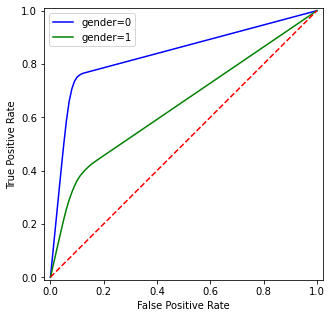

In [95]:
evaluate_fairer_clf(jobs, constraint="demographic_parity")

With this post-processing technique, the demographic parity between genders hold. We are loosing in accuracy but we could be happy to see that, with perfect equality between $\hat{P}(\hat{Y}=1 | G=1))$ and $\hat{P}(\hat{Y}=1 | G=0))$, the accuracy seems still pretty good. However, we still loose about 16% in accuracy and equal opportunity has been deteriorated. The model seems to perform quite poorly.

Surprisingly, after performing the post-processing algorithm, $\hat{P}(\hat{Y}=1 | Y=1, G=1)) < \hat{P}(\hat{Y}=1 | Y=1, G=0))$ contrary to the results of `evaluate_clf`. The constraint is certainly too strong. We repeat the post-processing strategy constraining on equal opportunity which generally matters more.

Accuracy: 0.7922166666666669
F1-score: 0.792071085228283
Precision score: 0.7926382007752427
Recall score: 0.7925339444636111
--------------------------------------
Demographic parity: 
p_yhat1_given_g1: 0.6093264815412666
p_yhat1_given_g0: 0.3984934469014203
p% score: 0.6559188370783725
-------------------
Equal opportunity: 
p_yhat1_given_y1_g1: 0.7905763539801091
p_yhat1_given_y1_g0: 0.7807953563306076
Equal opportunity score: 0.947187983688345


<ipython-input-94-330271987f23>:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal', 'datalim')


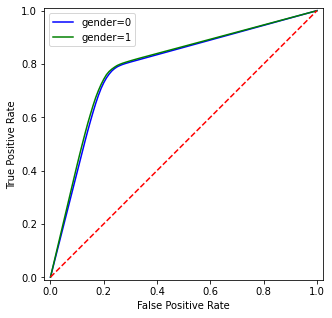

In [96]:
evaluate_fairer_clf(jobs, constraint="equalized_odds")

These results are more satisfactory as the reduction in accuracy is clearly less significant (about 6%). Equal odds hold and demographic parity is slightly positively affected, reducing the gap between genders compared to the results of `evaluate_clf`. The average ROC curves look much better.

**10. Find a fair thresholding rule on the prediction of your classifier**

We plotted the average ROC curves for both groups and this is not easy to find a fair thresholding rule. Equality between both true positive rates and false positive rates (equalized odds) would be too strict in the first case where we are already constraining on demographic parity. But we could take a threshold such that the true positive rates of the two groups are equal.
In the second case, as we contrained our post-processing on equalized odds, the two curves coincide already. 